In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()

import scipy.stats as stats

import statsmodels.tsa.api as smt_api
import statsmodels.tsa.stattools as smt_stat
import statsmodels.graphics.tsaplots as smg
import statsmodels.tsa.arima.model as smt_arima

import pandas_datareader.data as web

import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

# Data

https://fred.stlouisfed.org/series/PMAIZMTUSDM  
**Global price of Corn** downloaded from the [FRED database](https://fred.stlouisfed.org/) using [pandas-datareader](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-fred).

In [2]:
data = web.DataReader('PMAIZMTUSDM', 'fred', start='2000')
ret = data.pct_change().dropna()
ret

,PMAIZMTUSDM
DATE,
2000-02-01,0.022897
2000-03-01,0.000923
2000-04-01,0.003888
2000-05-01,-0.000092
2000-06-01,-0.120287
...,...
2023-10-01,-0.008690
2023-11-01,-0.057963
2023-12-01,-0.007857


In [3]:
ret.to_excel('Corn_returns.xlsx')

In [4]:
def plot_data_qqplot(data):
    fig = plt.figure(figsize=(10,8), layout='tight')
    axs = fig.subplot_mosaic([['data', 'data'],
                              ['hist', 'normplot']],
                             height_ratios=[2,3])
    # plot the data
    axs['data'].plot(data)
    axs['data'].axhline(0, c='k', ls=':', lw=.5)
    axs['data'].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    axs['data'].set_title("Monthly Percent Change")

    # plot an histogram + kde + MLE normal fit
    mu, sigma = stats.norm.fit(data)
    x = np.linspace(data.min(), data.max(), 200)
    pdf_norm = stats.norm.pdf(x, loc=mu, scale=sigma)
    sns.histplot(data, ax=axs['hist'], bins=35, kde=True, stat='density', legend=False)
    axs['hist'].plot(x, pdf_norm, c='r', lw=2)
    axs['hist'].xaxis.set_major_formatter(mtick.PercentFormatter(1))
    label = f"Best normal fit\n($\mu$={mu:.2%}, $\sigma$={sigma:.2%})"
    lines = axs['hist'].get_lines()
    axs['hist'].legend(lines, ['kde', label], fontsize='small')
    axs['hist'].set_title("Histogram")

    stats.probplot(data.values[:,0], plot=axs['normplot'])
    axs['normplot'].set_title("Normal Probability plot")

    fig.suptitle("Global price of Corn")
    

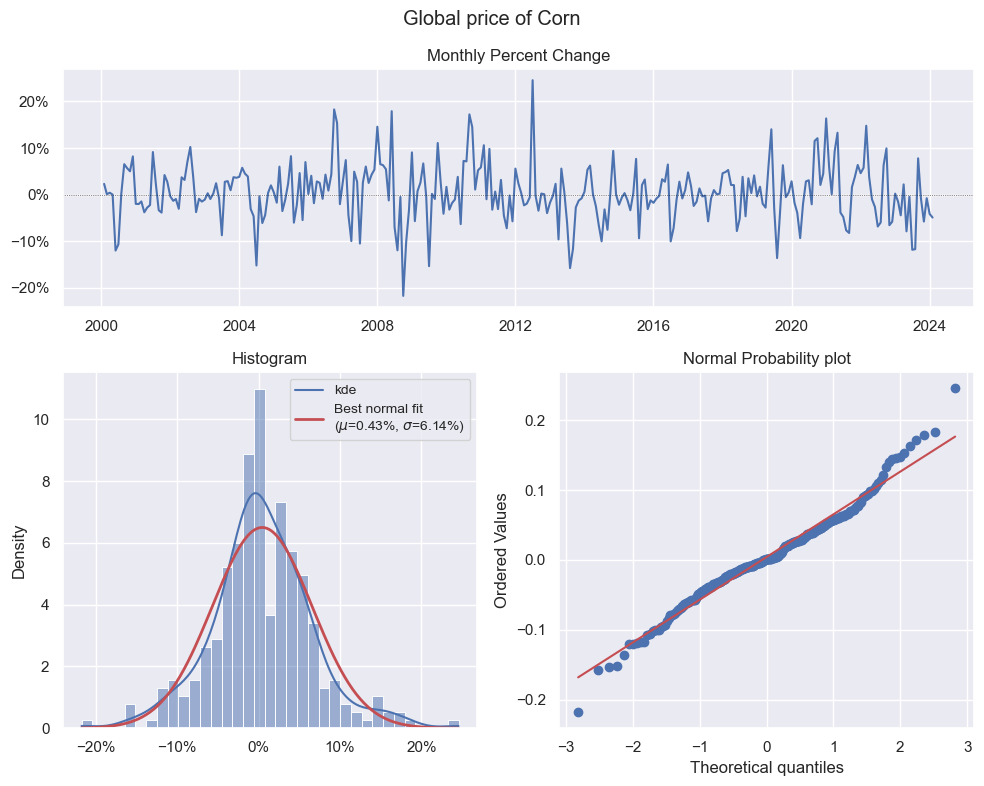

In [5]:
plot_data_qqplot( ret )

# Tests of stationarity

## Augmented Dickey-Fuller unit root test
The **Null hypothesis** of the Augmented Dickey-Fuller is that there is a unit root vs. the **Alternative hypothesis** of stationarity or trend stationarity (set by the `regression` parameter).  
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html

In [6]:
def print_adf_test(x):
    regressions = {'no constant, no trend': 'n',
                   'constant and trend': 'ct',
                   'constant only': 'c'}
    df = pd.DataFrame(data=np.zeros((len(regressions),2)),
                      index=regressions,
                      columns=['test statistic', 'p-value'])
    for reg in regressions:
        res = smt_api.adfuller(x, regression=regressions[reg])
        df.loc[reg, 'test statistic'] = res[0]
        df.loc[reg, 'p-value'] = res[1]
    display(df.round(4))

In [7]:
print_adf_test(ret)

,test statistic,p-value
"no constant, no trend",-12.8064,0.0
constant and trend,-12.8261,0.0
constant only,-12.8303,0.0


## KPSS test
The null hypothesis for the KPSS test is
- `regression='c'`: the data is stationary around a constant (default).
- `regression='ct'`: the data is stationary around a trend.

<https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html>

In [8]:
def print_kpss_test(x, regression='c'):
    regressions = {'constant only': 'c',
                   'constant and trend': 'ct'}
    df = pd.DataFrame(data=np.zeros((len(regressions),2)),
                      index=regressions,
                      columns=['test statistic', 'p-value'])
    for reg in regressions:
        res = smt_api.kpss(x, regression=regressions[reg], nlags='auto')
        df.loc[reg, 'test statistic'] = res[0]
        df.loc[reg, 'p-value'] = res[1]
    display(df.round(4))

In [9]:
print_kpss_test(  ret   )

/var/folders/d5/d0x5h6650dx_qwvg0pwpw1q43rqlyr/T/ipykernel_36466/3396425873.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = smt_api.kpss(x, regression=regressions[reg], nlags='auto')
/var/folders/d5/d0x5h6650dx_qwvg0pwpw1q43rqlyr/T/ipykernel_36466/3396425873.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = smt_api.kpss(x, regression=regressions[reg], nlags='auto')


,test statistic,p-value
constant only,0.0841,0.1
constant and trend,0.0468,0.1


# Testing the data for autocorrelation

## Plot the *autocorrelation* function and the *partial autocorrelation* function
- https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
- https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html

In [10]:
def plot_acf_pacf(x, lags=30):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    smg.plot_acf(x, lags=lags, ax=axs[0])
    smg.plot_pacf(x, lags=lags, ax=axs[1], method='yw')
    
    # add the 95% confidence interval using variance = 1/N
    stderr = stats.norm.ppf(.975) / np.sqrt(len(x))
    for ax in axs:
        ax.hlines([stderr, -stderr], 0, lags, colors='r', linestyles='dotted', label='95% confidence interval')
        ax.legend()

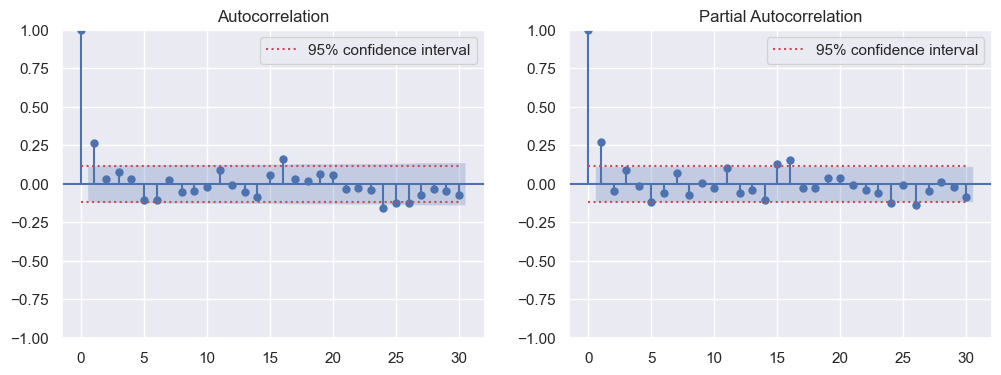

In [11]:
plot_acf_pacf(ret)

## Another view of autocorrelation

In [12]:
def scatter_plots(data, lags):
    fig, axs = plt.subplots(1, 2, figsize=(12,4), subplot_kw={'aspect': 'equal'})
    for ax, lag in zip(axs, lags):
        ax.scatter(data[:-lag], data[lag:], alpha=0.5, marker='.')
        ax.set_ylabel("data at time $t$")
        ax.set_xlabel(f"data at time $t-${lag}")
        ax.set_title(f"Autocorrelation at lag {lag}")

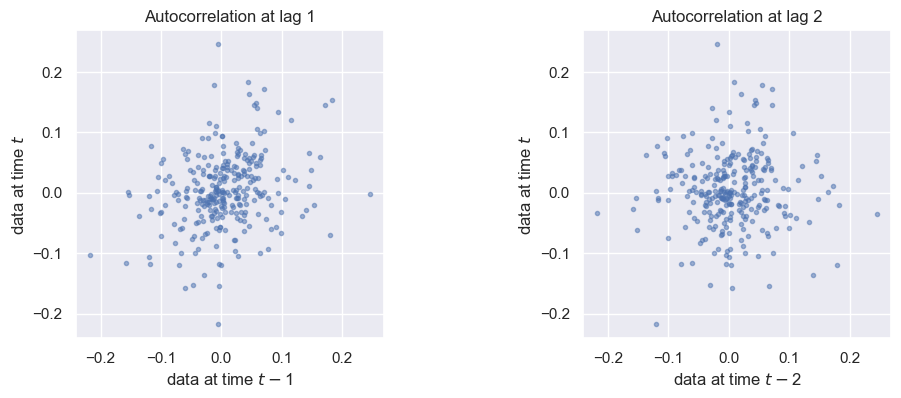

In [13]:
scatter_plots(data=ret, lags=[1, 2])

## Ljung-Box Q test

The `acf` function returns the acf values, . With the parameter `qstat=True`, it returns the Ljung-Box Q statistic and its p-values, computed for all lags up to `nlags`.\
<https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html>

In [14]:
def print_acf(x, lags):
    val, qstat, pval = smt_api.acf(x, fft=False, qstat=True, nlags=lags.max())
    df = pd.DataFrame(np.array([qstat[lags-1], 100 * pval[lags-1]]).T,
                      columns=['Q Statistic', 'p-value (%)'],
                      index=[f'up to lag {lag}' for lag in lags]).round(2)
    display(df)

In [15]:
test_lags = np.array([1, 2, 3, 5, 7, 10])
print_acf(ret, lags=test_lags)

,Q Statistic,p-value (%)
up to lag 1,20.89,0.00
up to lag 2,21.16,0.00
up to lag 3,22.98,0.00
up to lag 5,26.38,0.01
up to lag 7,29.99,0.01
up to lag 10,31.60,0.05


# Fitting an ARMA model

## Selecting a model with information criteria
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.arma_order_select_ic.html  
`trend='c'` includes constant  
`trend='n'` no constant: long run mean is zero

Function that displays the output of the `arma_order_select_ic` method

In [16]:
def select_arma(x, max_ar=2, max_ma=2, trend='c'):
    res = smt_stat.arma_order_select_ic(x,
                                       max_ar=max_ar,
                                       max_ma=max_ma,
                                       ic=['aic', 'bic'],
                                       trend=trend
                                      )
    res['aic'].index.names = ['AR Lags']
    res['aic'].columns.names = ['MA Lags']
    res['bic'].index.names = ['AR Lags']
    res['bic'].columns.names = ['MA Lags']
    res['aic'].columns = pd.MultiIndex.from_product([['AIC'],res['aic'].columns])
    res['bic'].columns = pd.MultiIndex.from_product([['BIC'],res['bic'].columns])

    display(res['aic'].round(1))
    print('AIC selected order: ', res['aic_min_order'])
    display(res['bic'].round(1))
    print('BIC selected order: ', res['bic_min_order'])
    
    return res

In [20]:
res = select_arma( ret , max_ar=1  , max_ma=3   )

AIC                     
MA Lags      0      1      2      3
AR Lags                            
0       -789.0 -809.6 -807.6 -806.7
1       -808.4 -807.6 -805.7 -805.1

AIC selected order:  (0, 1)


BIC                     
MA Lags      0      1      2      3
AR Lags                            
0       -781.6 -798.6 -792.9 -788.4
1       -797.4 -792.9 -787.4 -783.1

BIC selected order:  (0, 1)


## Estimation of the selected ARMA model
We fit an ARMA model to the data

We use the statsmodel `ARIMA` class that allows to model up to general SARIMAX models.  
<https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html>  
`order = (AR lags, Integration order, MA lags)`  

1. Instantiate the model.
2. Apply the `fit` method: <https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.fit.html>.
3. Display the fitted model with the `summary` method.

The output is an object of the class `ARIMAResults`. We use the `summary()` method to display the estimated model.  
<https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.html>

In [21]:
model = smt_arima.ARIMA(ret, order=(0,0,1))
fitted_model = model.fit()
fitted_model.summary()

/Users/eandre/opt/anaconda3/envs/ASTAT/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eandre/opt/anaconda3/envs/ASTAT/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eandre/opt/anaconda3/envs/ASTAT/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            PMAIZMTUSDM   No. Observations:                  289
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 407.803
Date:                Mon, 25 Mar 2024   AIC                           -809.606
Time:                        14:12:07   BIC                           -798.606
Sample:                    02-01-2000   HQIC                          -805.198
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.004      0.961      0.336      -0.004       0.013
ma.L1          0.2841      0.052      5.428      0.000       0.182       0.387
sigma2         0.0035      0.000     16.039      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                31.18
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.15
Prob(H) (two-sided):                  0.54   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Residuals analysis

The `ARIMAResults` class has a [`plot_diagnostics()` method](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMAResults.plot_diagnostics.html) to display an analysis of the residuals.

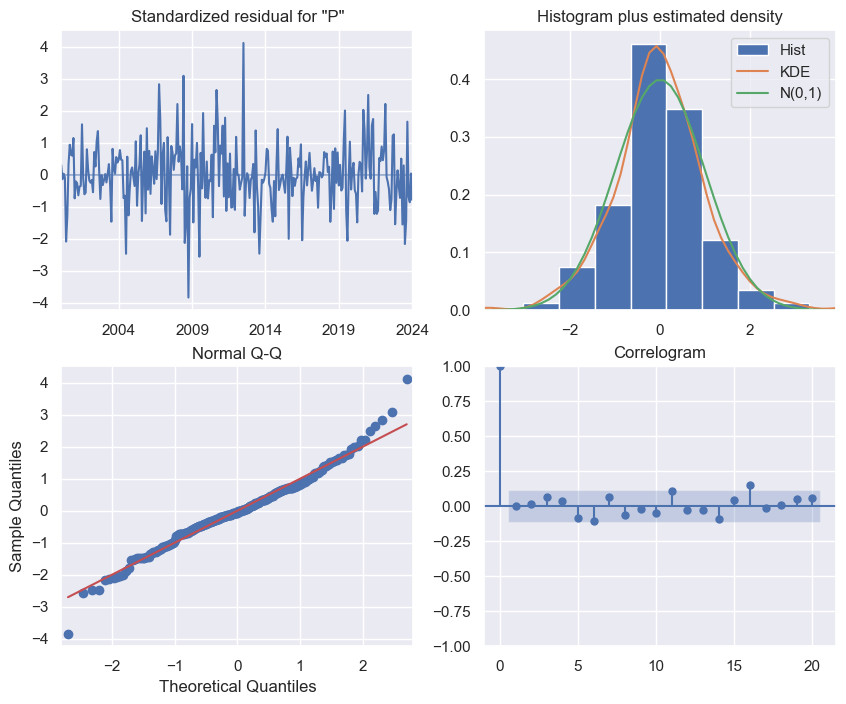

In [22]:
fig = fitted_model.plot_diagnostics(figsize=(10,8), lags=20)

We confirm the absence of autocorrelation seen in the Correlogram with the L-B Q Test.  
This proves that the ARMA model has captured most of the autocorrelation structure that is in the GDQ Q/Q changes data.

In [25]:
res = print_acf(fitted_model.resid , lags=test_lags)

,Q Statistic,p-value (%)
up to lag 1,0.00,97.16
up to lag 2,0.05,97.59
up to lag 3,1.31,72.75
up to lag 5,3.86,56.92
up to lag 7,8.52,28.92
up to lag 10,10.45,40.22


# Forecast

In [26]:
forecast = fitted_model.get_forecast(5)

In [28]:
df_forecast = forecast.summary_frame()
df_forecast

PMAIZMTUSDM,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-03-01,-0.007172,0.058998,-0.122806,0.108462
2024-04-01,0.004315,0.061333,-0.115896,0.124525
2024-05-01,0.004315,0.061333,-0.115896,0.124525
2024-06-01,0.004315,0.061333,-0.115896,0.124525
2024-07-01,0.004315,0.061333,-0.115896,0.124525


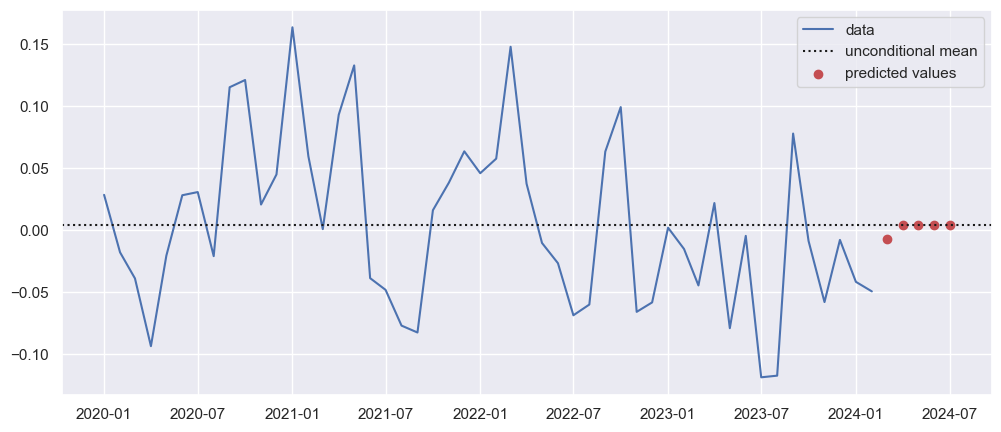

In [29]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(ret['2020':], label="data")
ax.axhline(ret['PMAIZMTUSDM'].mean(), c='k', ls=':', label="unconditional mean")
ax.scatter(df_forecast.index, df_forecast['mean'], c='r', label="predicted values")
ax.legend();